# SEPP

This is the full-blown, self-excited point process model with non-parametric kernels.

In [1]:
%matplotlib inline
from common import *
#datadir = os.path.join("//media", "disk", "Data")
datadir = os.path.join("..", "..", "..", "..", "..", "Data")

In [2]:
south_side, points = load_data(datadir)

In [3]:
masked_grid = grid_for_south_side()

## Train

In [4]:
import open_cp.sepp as sepp
import importlib
importlib.reload(sepp)

<module 'open_cp.sepp' from 'C:\\Users\\Matthew\\Documents\\m_drive\\GitHub\\PredictCode\\open_cp\\sepp.py'>

In [5]:
import open_cp.logger
open_cp.logger.log_to_true_stdout()

In [6]:
trainer = sepp.SEPPTrainer()
trainer.data = points

predictor = trainer.train(iterations=100)

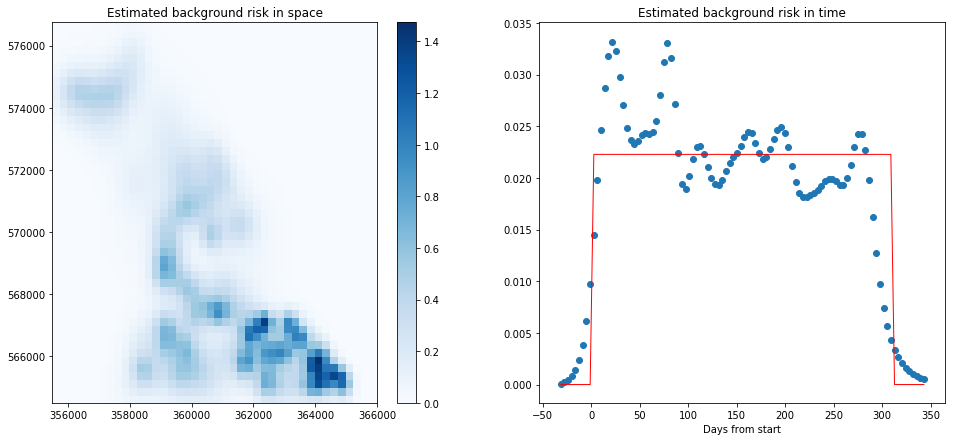

In [11]:
import open_cp.predictors

region = masked_grid.region()
def plot_density(predictor, ax):
    kernel_array = open_cp.predictors.grid_prediction_from_kernel(predictor.background_kernel.space_kernel,
        region, masked_grid.xsize)
    ax.set(xlim=[region.xmin, region.xmax], ylim=[region.ymin, region.ymax])
    mesh = ax.pcolormesh(*kernel_array.mesh_data(), kernel_array.intensity_matrix * 10000, cmap="Blues")
    fig.colorbar(mesh, ax=ax)
    return kernel_array

fig, ax = plt.subplots(ncols=2, figsize=(16,7))
kernel_array = plot_density(predictor, ax[0])

# Time unit is minutes
total_time = points.time_deltas()[-1]
tc = np.linspace(-total_time * 0.1, total_time * 1.1, 100)
def actual(t):
    return ((t>=0) & (t<=total_time)) / total_time
days_tc = tc / 60 / 24
ax[1].plot(days_tc, actual(tc) * 10000, linewidth=1, color="r")
ax[1].scatter(days_tc , predictor.background_kernel.time_kernel(tc) * 10000)
ax[0].set_title("Estimated background risk in space")
ax[1].set_title("Estimated background risk in time")
ax[1].set_xlabel("Days from start")
None

## Stocastically decluster

Using the computed kernels, we take a sample of which points are estimated to be "background" and what the triggering events look like.

The most obvious problem is that the "triggered" events are aligned almost vertically North/South.  We would expect a much more homogeneous pattern; or at least also a strong east/west bias, reflecting the grid layout of Chicago.

In [8]:
backgrounds, aftershocks = sepp.sample_points(trainer.as_time_space_points(), predictor.result.p)

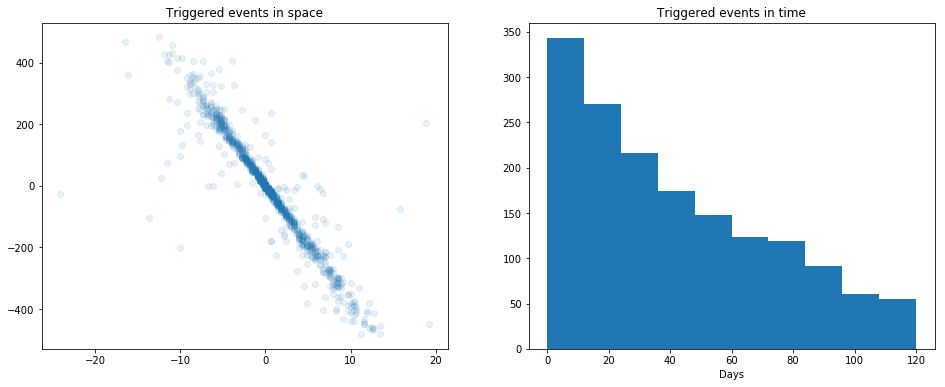

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(aftershocks[1], aftershocks[2], alpha=0.1)
ax[0].set_title("Triggered events in space")

ax[1].hist(aftershocks[0] / 60 / 24)
ax[1].set_title("Triggered events in time")
ax[1].set_xlabel("Days")
None

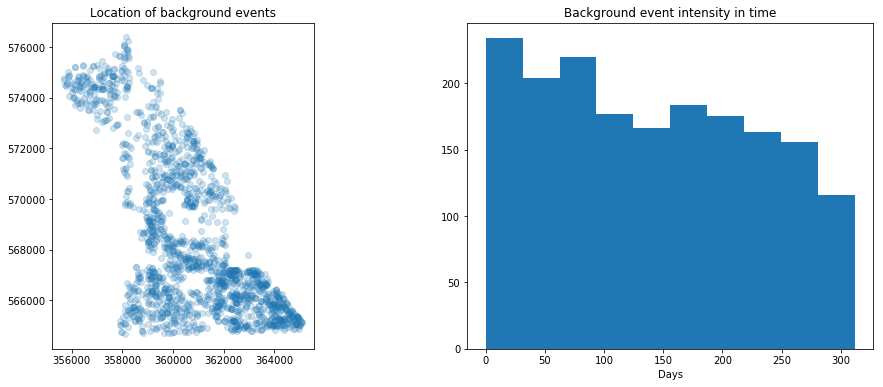

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(16,6))

ax[0].scatter(backgrounds[1], backgrounds[2], alpha=0.2)
ax[0].set_title("Location of background events")
ax[0].set_aspect(1)

ax[1].hist(backgrounds[0] / 60 / 24)
ax[1].set_title("Background event intensity in time")
ax[1].set_xlabel("Days")